In [2]:
from Image_preprocessing import preprocess
import os
import numpy as np
from skimage import io, exposure
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib as mpl
from pystackreg import StackReg
from skimage.filters import median
from PIL import Image



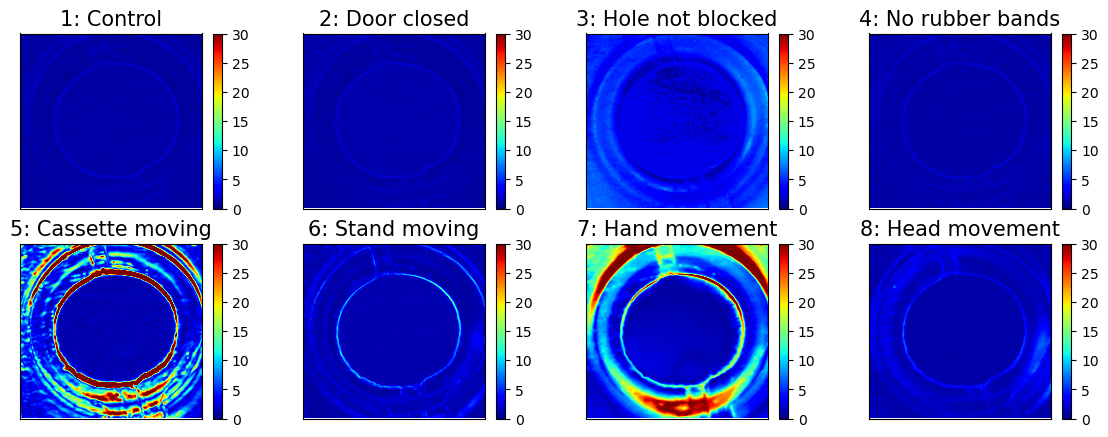

In [16]:
tests = ['basic_elastic', 'basic_elastic_closeddoor', 'no_hole_block', 'basic_no_elastic', 'cassette_moving', 'chasis_moving','hand_above', 'head_moving']
fig, axs = plt.subplots(2, 4, figsize=(14, 5))
for test, name in enumerate(tests):
    img_path = os.path.abspath(os.path.join(
        os.getcwd(),
        'tests',
        name
    ))

    imgs = list(io.imread_collection(img_path+'/*.bmp'))
    processed_imgs = []
    ref_img = io.imread('baseline_ref.png')
    baseline = io.imread('baseline_mean.png')
    #print(ref_img.shape)
    #ref_img = median(imgs[-1][ 220:800 , 350:950], np.ones((5,5))).astype('int16')
    #pil_img = Image.fromarray(ref_img).convert('L')
    #pil_img.save("baseline_ref.png")


    sr = StackReg(StackReg.RIGID_BODY)

    def stretch(v_min_d, v_max_d, img):
        v_min = np.min(img)
        v_max = np.max(img)
        g = ((v_max_d - v_min_d) / (v_max - v_min)) * (img - v_min) + v_min_d
        return np.round(g).astype('uint8')

    for i, img in enumerate(imgs):
        # CROPPING
        img = img[ 220:800 , 350:950]
        
        # MEDIAN FILTER 
        img = median(img, np.ones((5,5)) )
        
        # RIDIG REGISTRATION
        mov = img.astype('int16')
        #img = sr.register_transform(ref_img, mov).astype('uint8')
        
        # Crop little errors on the sides
        img = img[15:-15, 15:-15]

        # HISTOGRAM STRETCHING
        img = stretch(0,255, img)
        
        # HISTOGRAM MATCHING
        #img = exposure.match_histograms(img, baseline)
        processed_imgs.append(img)


    # MEAN/STD PROCESSED IMG
    mean_img = np.array(processed_imgs).mean(axis=0)
    std_img = np.array(processed_imgs).std(axis=0)
    

    # QUALITY SCORES
    quality_score = []
    diff_imgs = []
    for img in processed_imgs:
        img = img.astype('int16')
        diff_img = abs(baseline - img)
        diff_img[diff_img < 10] = 0
        diff_imgs.append(diff_img)
        quality_score.append(int(np.sum(diff_img/1000)))
    diff_imgs = np.array(diff_imgs)
    quality_score = np.array(quality_score)

    # plot
    names = ['Control','Door closed','Hole not blocked','No rubber bands','Cassette moving','Stand moving','Hand movement','Head movement']
    axs[test//4, test%4].set_title(f"{test+1}: {names[test]}", fontsize=15)
    axs[test//4, test%4].set_xticks([])
    axs[test//4, test%4].set_yticks([])
    show = axs[test//4, test%4].imshow(std_img, cmap='jet')
    show.set_clim(vmin=0, vmax=30)
    fig.colorbar(show, ax=axs[test//4, test%4])
    # fig.suptitle("Mean Difference Image and Quality Score", fontsize=30)
    
plt.show()

In [3]:
img_path = os.path.abspath(os.path.join(
        os.getcwd(),
        'tests',
        'preproc_test'
    ))
imgs = list(io.imread_collection(img_path+'/*.bmp'))
processed_imgs = []

baseline = io.imread('baseline_mean.png')
ref_img = io.imread('baseline_ref.png')
# ref_img = median(np.array(imgs).mean(axis=0)[ 220:800 , 350:950], np.ones((5,5))).astype('int16')
# ref_img = median(np.array(imgs).mean(axis=0)[ 170:750 , 350:950], np.ones((5,5))).astype('int16')
# pil_img = Image.fromarray(ref_img).convert('L')
# pil_img.save("baseline_ref(old_control).png")

sr = StackReg(StackReg.RIGID_BODY)


def stretch(v_min_d, v_max_d, img):
    v_min = np.min(img)
    v_max = np.max(img)
    g = ((v_max_d - v_min_d) / (v_max - v_min)) * (img - v_min) + v_min_d
    return np.round(g).astype('uint8')

for i, img in enumerate(imgs):
    # CROPPING
    img = img[ 220:800 , 350:950]
    #img = img[ 170:750 , 350:950]
    
    # MEDIAN FILTER 
    img = median(img, np.ones((5,5)) )
    
    # RIDIG REGISTRATION
    mov = img.astype('int16')
    img = sr.register_transform(ref_img, mov).astype('uint8')
    
    # Crop little errors on the sides
    img = img[15:-15, 15:-15]

    # HISTOGRAM STRETCHING
    img = stretch(0,255, img)
    
    # (HISTOGRAM MATCHING)
    img = exposure.match_histograms(img, baseline)
    processed_imgs.append(img)


# baseline = np.array(processed_imgs).mean(axis=0)    
# pil_img = Image.fromarray(baseline).convert('L')
# pil_img.save("baseline_mean(old_control).png")

In [ ]:
for i in range(8):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].imshow(imgs[i], cmap='gray')
    axs[1].hist(imgs[i].ravel(), bins=256, range=(0, 255), fc='k', ec='k', density=True)
    axs[1].set_ylim(0, 0.02)
    axs[2].imshow(processed_imgs[i], cmap='gray')
    axs[3].hist(processed_imgs[i].ravel(), bins=256, range=(0, 255), fc='k', ec='k', density=True)
    axs[3].set_ylim(0, 0.02)
    
    plt.show()

# Concatenate images

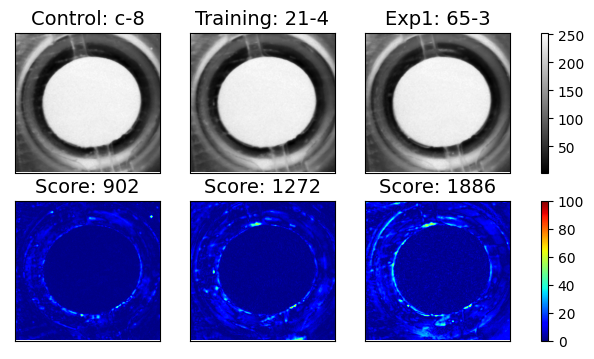

In [6]:
img_path = os.path.abspath(os.path.join(
        os.getcwd(),
        'tests',
        'score_best_image'
    ))
imgs = list(io.imread_collection(img_path+'/*.bmp'))
baseline = io.imread('baseline_mean.png').astype('int16')

fig, axs = plt.subplots(2,3, figsize=(8,4))
fontsize = 14
axs[0,0].set_title("Control: c-8", fontsize=fontsize)
axs[0,0].imshow(imgs[12], cmap='gray')
axs[1,0].set_title("Score: 902", fontsize=fontsize)
axs[1,0].imshow(abs(baseline-imgs[12]), cmap='jet', vmin=0, vmax=100)

axs[0,1].set_title("Training: 21-4", fontsize=fontsize)
axs[0,1].imshow(imgs[10], cmap='gray')
axs[1,1].set_title("Score: 1272", fontsize=fontsize)
axs[1,1].imshow(abs(baseline-imgs[10]), cmap='jet', vmin=0, vmax=100)

axs[0,2].set_title("Exp1: 65-3", fontsize=fontsize)
im1 = axs[0,2].imshow(imgs[11], cmap='gray')
axs[1,2].set_title("Score: 1886", fontsize=fontsize)
im2 = axs[1,2].imshow(abs(baseline-imgs[11]), cmap='jet', vmin=0, vmax=100)

fig.colorbar(im1, ax=np.array([axs[0,0],axs[0,1],axs[0,2]]).tolist())
fig.colorbar(im2, ax=np.array([axs[1,0],axs[1,1],axs[1,2]]).tolist())

for i in range(6):
    axs[i//3, i%3].set_xticks([])
    axs[i//3, i%3].set_yticks([])

plt.show()

# Inspect single images

In [46]:
img_path = os.path.abspath(os.path.join(
        os.getcwd(),
        'tests',
        'similar_score_comparison',
        'below'
    ))
imgs = list(io.imread_collection(img_path+'/*.bmp'))
baseline = io.imread('baseline_mean.png').astype('int16')


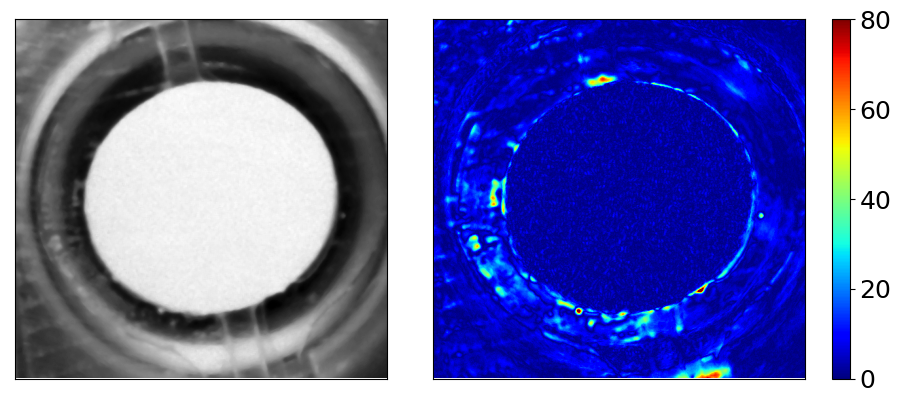

In [51]:
index = 4
fig, axs = plt.subplots(1,2, figsize=(9,3))
axs[0].imshow(imgs[index], cmap='gray')
im = axs[1].imshow(abs(baseline-imgs[index]), cmap='jet')
cbar = fig.colorbar(im, ax=axs[1],ticks=[0,20,40,60,80])
cbar.ax.tick_params(labelsize=18)  
im.set_clim(0,80)

for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])


#fig.suptitle("Exp X-Y (Impurity=123)", fontsize=15)

fig.subplots_adjust()
fig.tight_layout(pad=-3)
plt.show()

# Preprocessing comparison

In [2]:
def get_impurity(img, baseline):
    img = img.astype('int16')
    diff_img = abs(img-baseline)
    return int(np.sum(diff_img/1000))

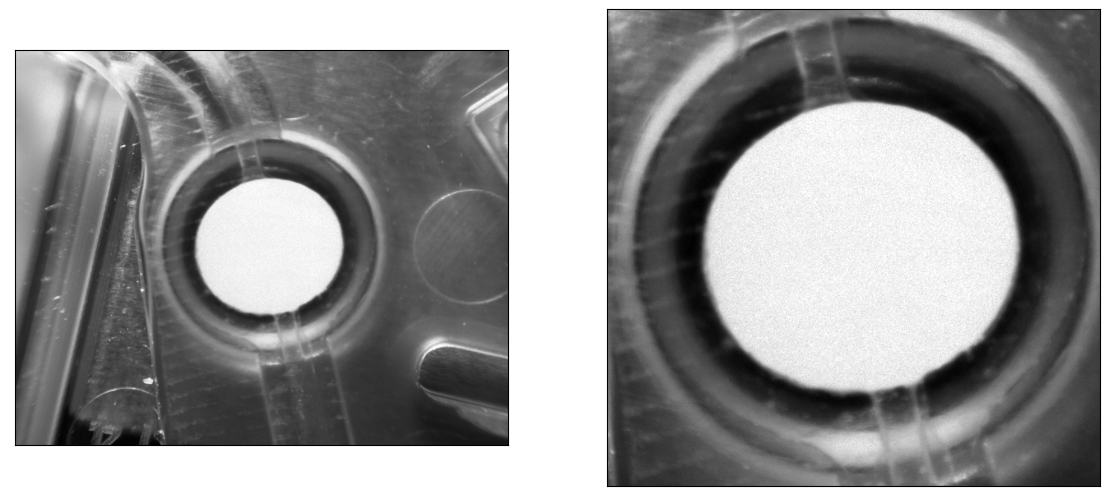

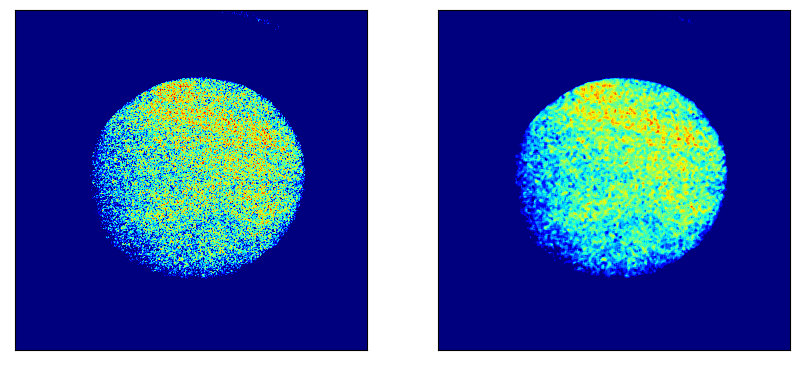

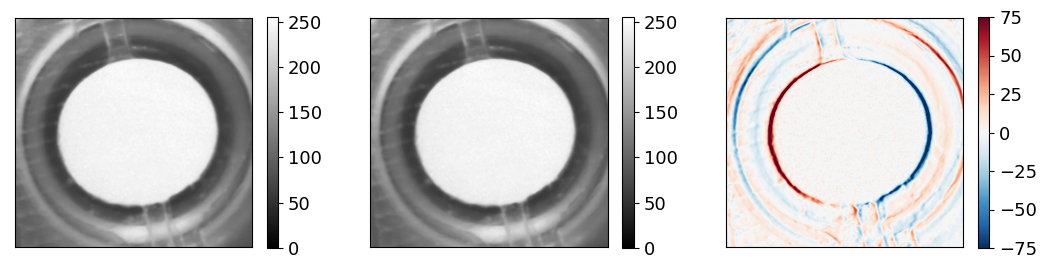

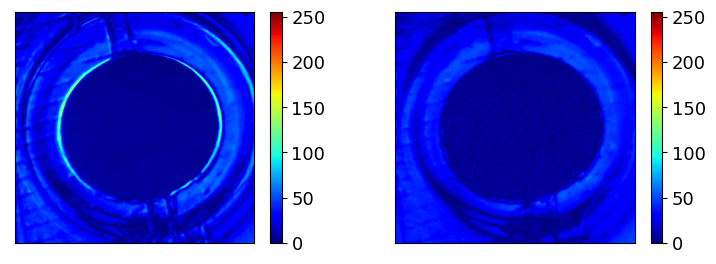

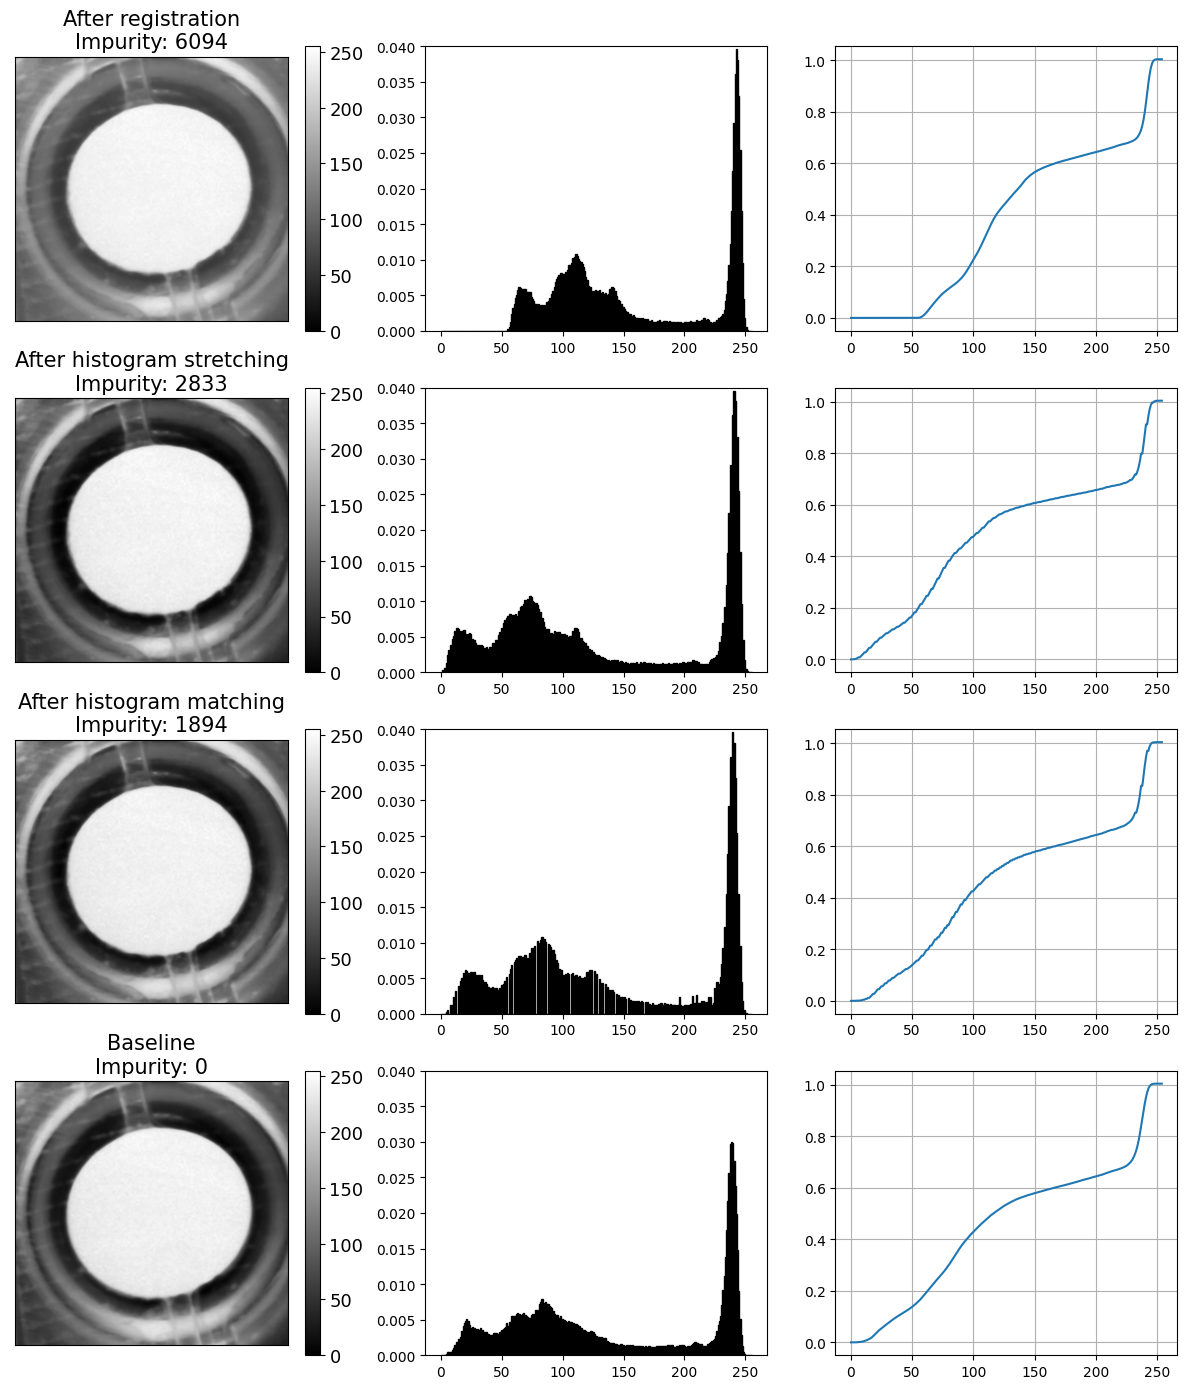

In [5]:
img_path = os.path.abspath(os.path.join(
        os.getcwd(),
        'tests',
        'preproc_test'
    ))
imgs = list(io.imread_collection(img_path+'/*.bmp'))

processed_imgs = []
baseline = io.imread('baseline_mean.png')
ref_img = io.imread('baseline_ref.png')
index = 5

sr = StackReg(StackReg.RIGID_BODY)

def stretch(v_min_d, v_max_d, img):
    v_min = np.min(img)
    v_max = np.max(img)
    g = ((v_max_d - v_min_d) / (v_max - v_min)) * (img - v_min) + v_min_d
    return np.round(g).astype('uint8')



img0 = imgs[index]

# CROPPING
img1 = img0[ 220:800 , 350:950]
#img = img[ 170:750 , 350:950]

# MEDIAN FILTER 
img2 = median(img1, np.ones((5,5)) )

# RIDIG REGISTRATION
mov = img2.astype('int16')
img3 = sr.register_transform(ref_img, mov).astype('uint8')

# Crop little errors on the sides
img4 = img3[15:-15, 15:-15]

# HISTOGRAM STRETCHING
img5 = stretch(0,255, img4)

# (HISTOGRAM MATCHING)
img6 = exposure.match_histograms(img5, baseline)


####### CROPPING ########
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(img0, cmap='gray')
axs[1].imshow(img1, cmap='gray')
for i in range(2): 
    axs[i].set_xticks([]) 
    axs[i].set_yticks([])
plt.show()
###### MEDIAN FILTER #########
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot1 = axs[0].imshow(img1, cmap='jet')
plot2 = axs[1].imshow(img2, cmap='jet')
plot1.set_clim(235, 255)
plot2.set_clim(235, 255)
# cbar1 = fig.colorbar(plot1, ax=axs[0])
# cbar2 = fig.colorbar(plot2, ax=axs[1])
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()
####### RIGID REGISRTATION ########
fig, axs = plt.subplots(1, 3, figsize=(13, 3))
plot1 = axs[0].imshow(img2[15:-15, 15:-15], cmap='gray')
plot2 = axs[1].imshow(img3[15:-15, 15:-15], cmap='gray')
plot3 = axs[2].imshow(img2[15:-15, 15:-15].astype('int16')-img3[15:-15, 15:-15].astype('int16'), cmap='RdBu_r')
plot1.set_clim(0, 255)
plot2.set_clim(0, 255)
plot3.set_clim(-75, 75)
plots = [plot1, plot2, plot3]
for i in range(3):
    cbar = plt.colorbar(plots[i], ax=axs[i])
    cbar.ax.tick_params(labelsize=13)  
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()
####### RIGID REGISRTATION - COMPARE BASELINE ########
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
compare_img2 = abs(img2[15:-15, 15:-15].astype('int16') - baseline.astype('int16'))
compare_img3 = abs(img3[15:-15, 15:-15].astype('int16') - baseline.astype('int16'))
plot1 = axs[0].imshow(compare_img2, cmap='jet')
plot2 = axs[1].imshow(compare_img3, cmap='jet')
plot1.set_clim(0, 255)
plot2.set_clim(0, 255)
plots = [plot1, plot2]
for i in range(2):
    cbar = plt.colorbar(plots[i], ax=axs[i])
    cbar.ax.tick_params(labelsize=13)  
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()
####### HISTOGRAM MATCHING ########
fig, axs = plt.subplots(4, 3, figsize=(15, 17))
plot1 = axs[0,0].imshow(img4, cmap='gray')
plot2 = axs[1,0].imshow(img5, cmap='gray')
plot3 = axs[2,0].imshow(img6, cmap='gray')
plot4 = axs[3,0].imshow(baseline, cmap='gray')


plot1.set_clim(0, 255)
plot2.set_clim(0, 255)
plot3.set_clim(0, 255)
plot4.set_clim(0, 255)

axs[0,1].hist(img4.ravel(), bins=256, range=(0, 255), fc='k', ec='k', density=True)
axs[1,1].hist(img5.ravel(), bins=256, range=(0, 255), fc='k', ec='k', density=True)
axs[2,1].hist(img6.ravel(), bins=256, range=(0, 255), fc='k', ec='k', density=True)
axs[3,1].hist(baseline.ravel(), bins=256, range=(0, 255), fc='k', ec='k', density=True)

hist1, bins1 = np.histogram(img4.ravel(), bins=256, range=(0, 255), density=True)
hist2, bins2 = np.histogram(img5.ravel(), bins=256, range=(0, 255), density=True)
hist3, bins3 = np.histogram(img6.ravel(), bins=256, range=(0, 255), density=True)
hist4, bins4 = np.histogram(baseline.ravel(), bins=256, range=(0, 255), density=True)

axs[0,2].plot(bins1[:-1], np.cumsum(hist1))
axs[1,2].plot(bins2[:-1], np.cumsum(hist2))
axs[2,2].plot(bins3[:-1], np.cumsum(hist3))
axs[3,2].plot(bins4[:-1], np.cumsum(hist4))

plots = [plot1, plot2, plot3, plot4]
for i in range(4):
    cbar = plt.colorbar(plots[i], ax=axs[i,0])
    cbar.ax.tick_params(labelsize=13) 
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_ylim(0,0.04)
    axs[i,2].grid()

    
fontsize = 15
axs[0,0].set_title(f"After registration\nImpurity: {get_impurity(img4,baseline)}", fontsize=fontsize)
axs[1,0].set_title(f"After histogram stretching\nImpurity: {get_impurity(img5,baseline)}", fontsize=fontsize)
axs[2,0].set_title(f"After histogram matching\nImpurity: {get_impurity(img6,baseline)}", fontsize=fontsize)
axs[3,0].set_title(f"Baseline\nImpurity: {get_impurity(baseline,baseline)}", fontsize=fontsize)

plt.show()